In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

C:\Users\imhj1\AppData\Local\Temp\ipykernel_9128\1289177811.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  A = pd.Series(index=range(T))
C:\Users\imhj1\AppData\Local\Temp\ipykernel_9128\1289177811.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  B = pd.Series(index=range(T))


Text(0.5, 1.0, 'Non-Stationary')

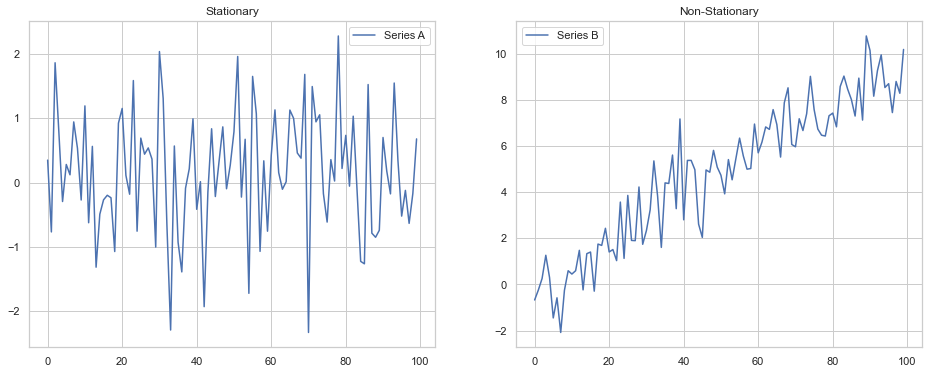

In [3]:
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

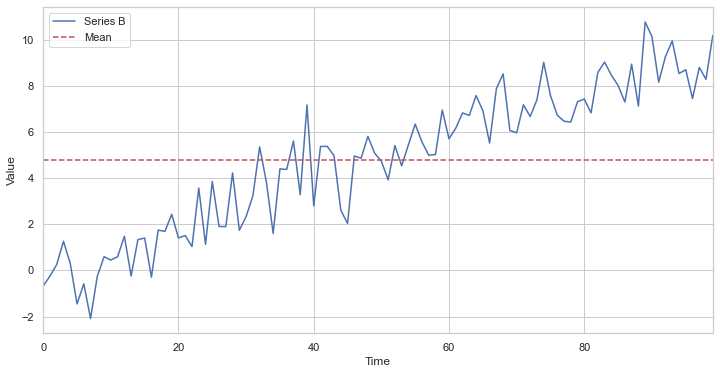

In [4]:
mean = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 99])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

In [5]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')


In [6]:
stationarity_test(A)
stationarity_test(B)

p-value = 6.58257207138782e-20 The series A is likely stationary.
p-value = 0.6907428762804994 The series B is likely non-stationary.


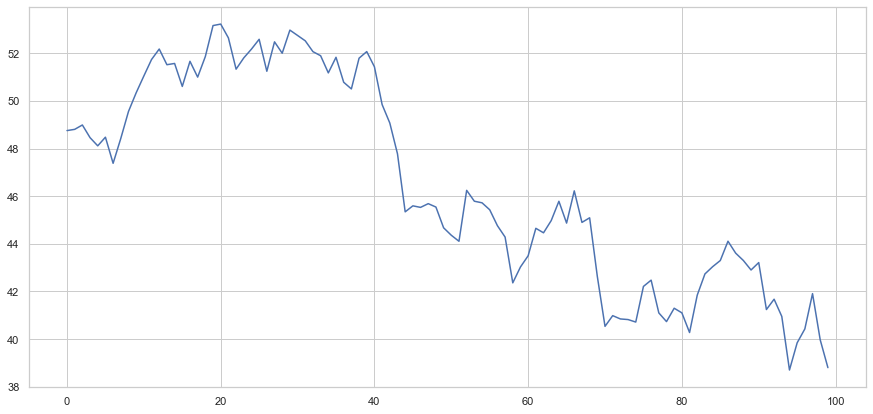

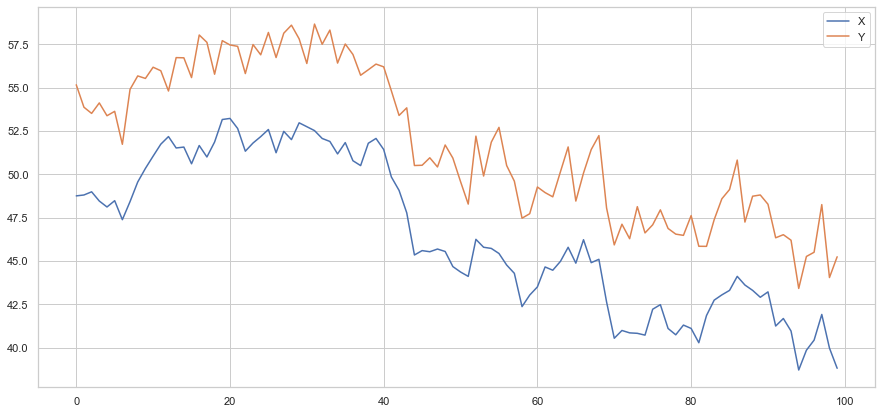

In [7]:
Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))

plt.show()

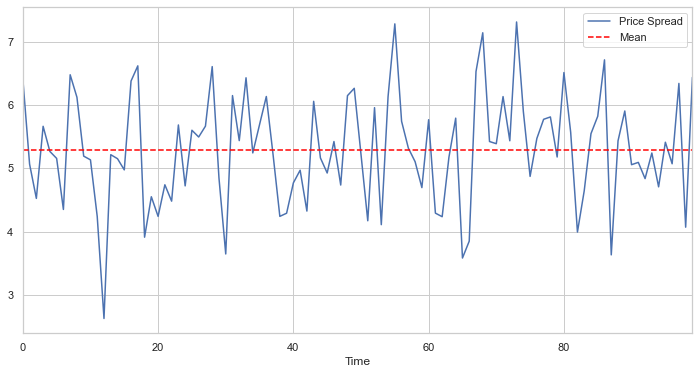

In [8]:
plt.figure(figsize=(12,6))
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean'])

In [9]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

1.0707850740870454e-13


(0.0, 99.0)

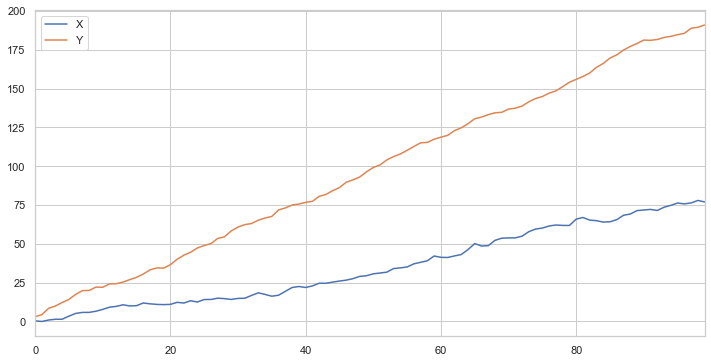

In [10]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99)

In [11]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))


Correlation: 0.9875758462665581
Cointegration test p-value: 0.7541331847918822


Correlation: -0.00623405671592415
Cointegration test p-value: 0.0


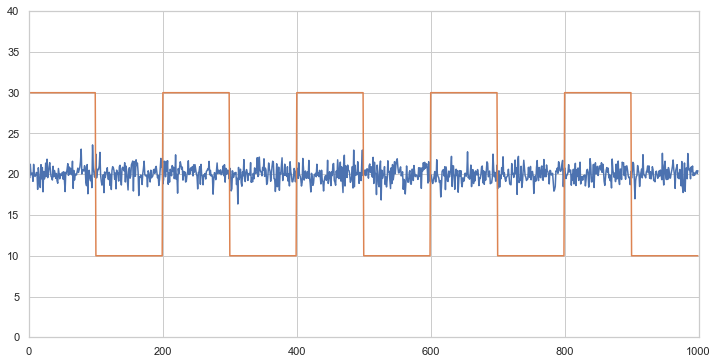

In [12]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

In [15]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [16]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [17]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2017-12-22,43.752499,175.000000,10.54,37.759998,21.26,145.793503,28.860001,85.510002,47.360001,64.730003,267.510010
2017-12-26,42.642502,174.440002,10.46,37.939999,21.23,146.108994,28.860001,85.400002,47.430000,64.300003,267.190002
2017-12-27,42.650002,175.360001,10.53,37.610001,21.27,146.395798,28.879999,85.709999,47.380001,64.540001,267.320007
2017-12-28,42.770000,175.550003,10.55,37.919998,21.15,147.265778,28.870001,85.720001,47.520000,64.379997,267.869995
2017-12-29,42.307499,175.240005,10.28,37.740002,21.01,146.673035,28.500000,85.540001,47.279999,64.019997,266.859985


[('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('HPQ', 'ORCL')]


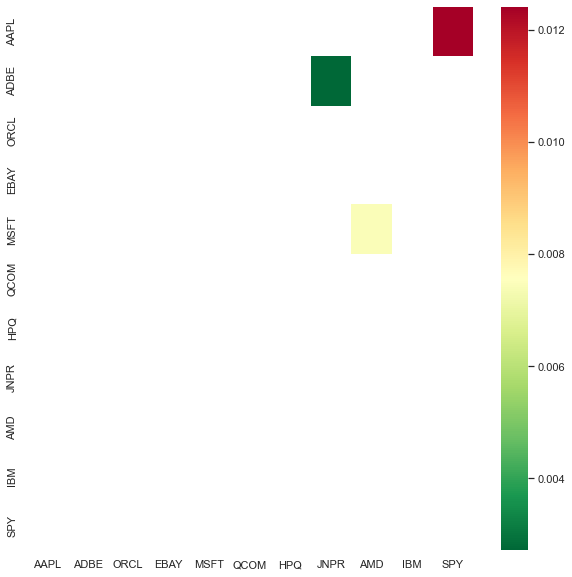

In [18]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [19]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.0027130169035165744

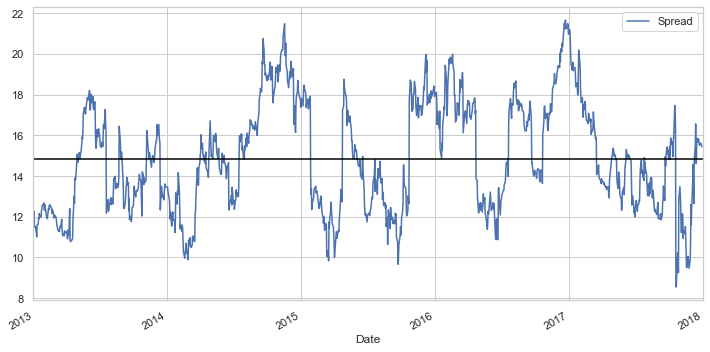

In [20]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread'])

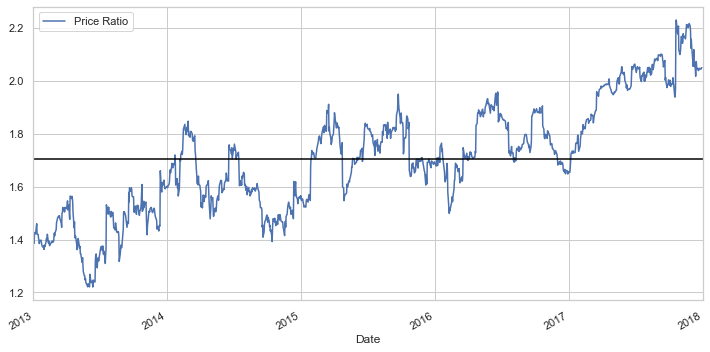

In [21]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio'])

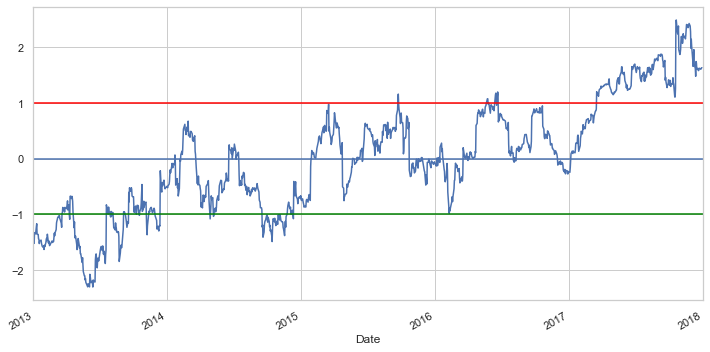

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

In [23]:
ratios = df['ADBE'] / df['MSFT'] 
print(len(ratios) * .70 ) 

882.0


In [24]:
train = ratios[:881]
test = ratios[881:]

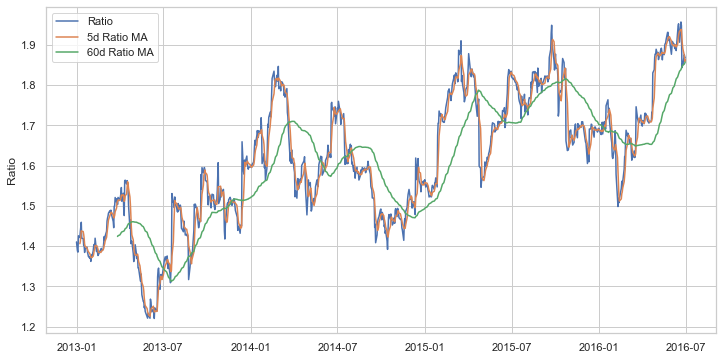

In [25]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

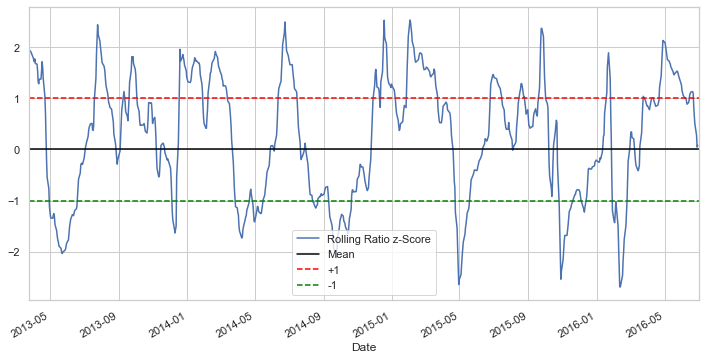

In [26]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

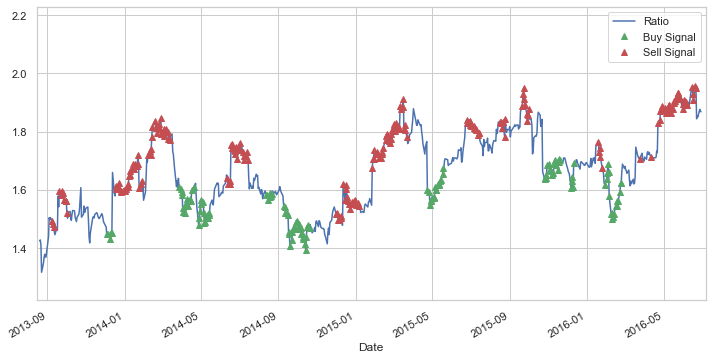

In [27]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

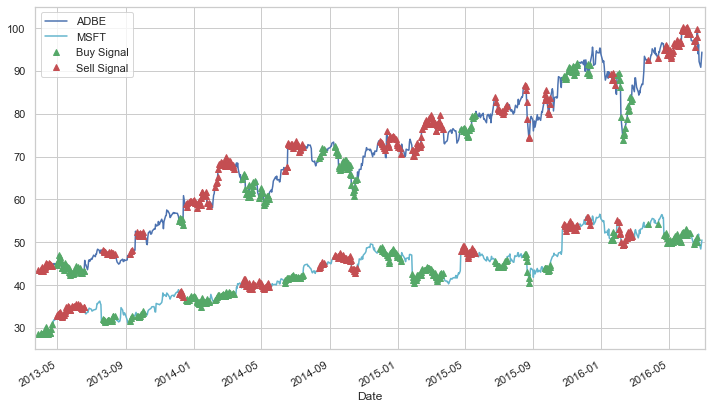

In [28]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:881]
S2 = df['MSFT'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [29]:
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [30]:
trade(df['ADBE'].iloc[881:], df['EBAY'].iloc[881:], 60, 5)

1314.449494779637